In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

from scipy.integrate import simps
from time import time 
import matplotlib.animation as animation


import importlib
from TIM_scan_strategy import *
from scan_fcts import *

In [6]:
mcmLat = -77.83
minLat = -85
maxLat = -75
latList = np.arange(minLat,maxLat,2.)

# --- SKy path ---

# http://simbad.u-strasbg.fr/simbad/sim-id?Ident=GOODS+South+field
c=SkyCoord.from_name('Goods-S Field')
print('GOODS-S:   {0:}'.format(c.to_string('hmsdms')))

goodsSDec = c.dec.value
sptDeepDec = -55.
# ------

HA = 0
dec= goodsSDec

alt = elevationAngle(dec,mcmLat,HA)
azi = azimuthAngle(  dec,mcmLat,HA)

dec2  = declinationAngle(np.degrees(azi), np.degrees(alt), mcmLat)
ha2   = hourAngle(np.degrees(azi), np.degrees(alt), mcmLat)
np.degrees([dec2,ha2])


GOODS-S:   03h32m28.0008s -27d48m29.988s


array([-2.78083300e+01, -8.53773646e-07])

Length: 240000


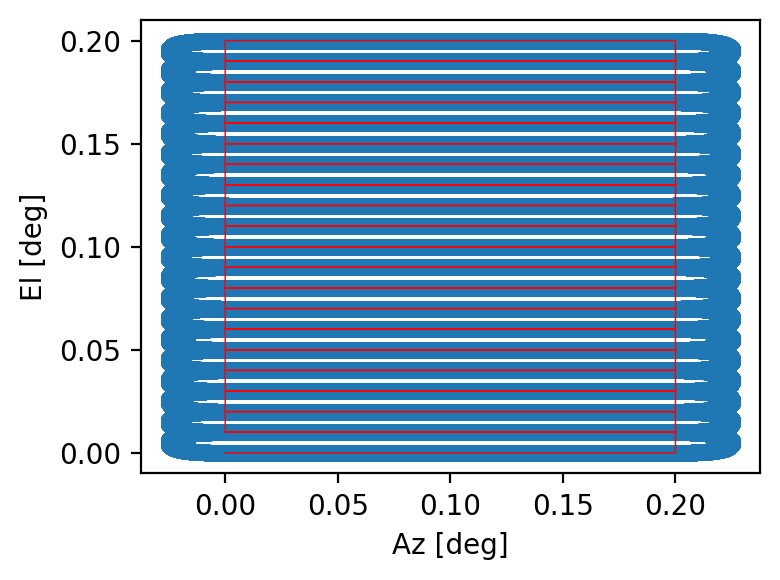

In [7]:
az, alt, flag, scan_eff, t = genLocalPath(az_size=0.2, alt_size=0.2, alt_step=0.01, acc=0.05, scan_v=0.05, dt=0.001)
print('Length:', len(az))

fig, ax = plt.subplots(figsize=(4,3), dpi=200)
plt.scatter(az,alt,lw=0.1)
plt.plot(az[flag==1],alt[flag==1],lw=0.5,c='r')
#ax.set_aspect(aspect=1)
plt.xlabel('Az [deg]')
plt.ylabel('El [deg]')
fig.tight_layout()
#plt.legend(frameon=1, fontsize=8)
#plt.savefig("scan_route.png")

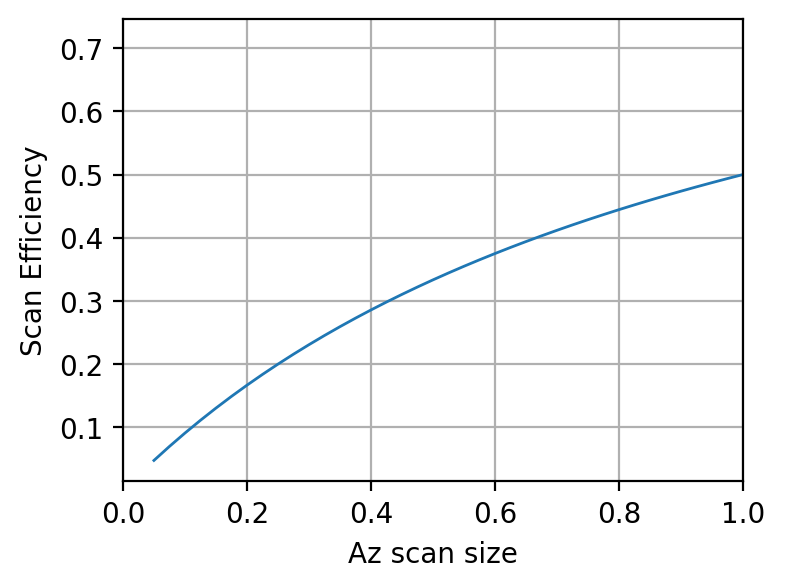

In [8]:
az_sizes = np.arange(0.05,2.5,0.025)
eff = []

for az_size in az_sizes:
    az, alt, flag, scan_eff,t = genLocalPath(az_size=az_size)
    eff.append(scan_eff)

fig, ax = plt.subplots(figsize=(4,3), dpi=200)
plt.plot(az_sizes,eff,lw=1., label='Scan Efficiency')
plt.xlim([0,1])
plt.ylabel('Scan Efficiency')
plt.xlabel('Az scan size')
plt.grid()
# plt.savefig("scan_eff.png")

In [10]:
hit_maps = [] 
pixel_xy_list = []
pixel_xy_LW_list = []

T_duration = 3600*15
dt = np.pi/3.14/122
T = np.arange(0,T_duration,dt)
HA = (-1*T_duration/2 + T)/3600. 

res=0.0033
f_range=0.6

az_list = (0.2,  )
for az_size in az_list:
    az, alt, flag, scan_eff,t = genLocalPath(az_size=az_size, alt_size=0.08, alt_step=0.02, acc=0.05, scan_v=0.05, dt=0.001)
    print(T.shape, alt.shape, az.shape, flag.shape)
    scan_path, scan_flag = genScanPath(T, alt, az, flag)
    
    scan_path = scan_path[scan_flag==1]
    T_trim = T[scan_flag==1]
    HA_trim = HA[scan_flag==1]
    theta = np.radians(0)

    pixel_offset = pixelOffset(64, 0.0148)
    pixel_offset_LW = pixelOffset(51, 0.0186)

    pixel_paths  = genPixelPath(scan_path, pixel_offset, theta)
    
    pixel_xy_list.append( np.array([-1*pixel_offset*np.sin(theta)-0.036*np.cos(theta), pixel_offset*np.cos(theta)-0.036*np.sin(theta)]) )
    pixel_xy_LW_list.append( np.array([-1*pixel_offset_LW*np.sin(theta)+0.036*np.cos(theta), pixel_offset_LW*np.cos(theta)+0.072*np.sin(theta)]) )

    pointing_paths = [genPointingPath(T_trim, pixel_path, HA_trim, mcmLat, dec) for pixel_path in pixel_paths]
    #np.save('TIM_deep_sky_hits_az%1.2f'%(az_size), np.array(pointing_paths))

    xedges,yedges,hit_map = binMap(pointing_paths,res=res,f_range=f_range,dec=dec)

    hit_maps.append(hit_map)

    

(6584661,) (48000,) (48000,) (48000,)


0


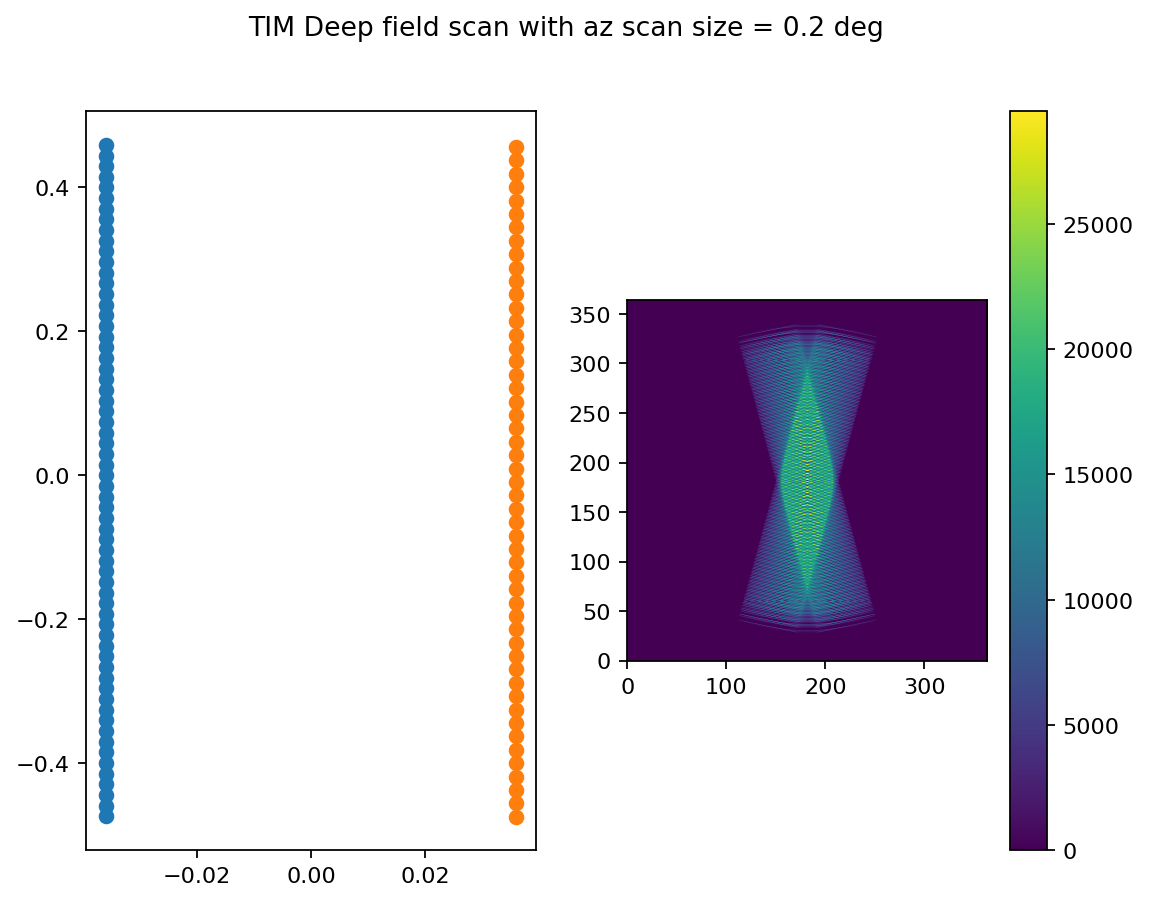

In [12]:
for i, (az, hitmap, pixel_xy, pixel_xy_LW) in enumerate(zip(az_list, hit_maps,pixel_xy_list, pixel_xy_LW_list)):
    print(i)
    fig, (axa,axb) = plt.subplots(1,2,figsize=(8,6), dpi=160)
    axa.scatter(pixel_xy[0],pixel_xy[1],)
    axa.scatter(pixel_xy_LW[0],pixel_xy_LW[1],)

    fig.suptitle(t='TIM Deep field scan with az scan size = %1.1f deg\n'%az)
    img = axb.imshow((hit_map), 
        interpolation='nearest', origin='lower', vmin=0, vmax=np.max(hit_map), )
    fig.colorbar(img, ax=axb,)

(6584661,) (6584661, 2) (6584661,)


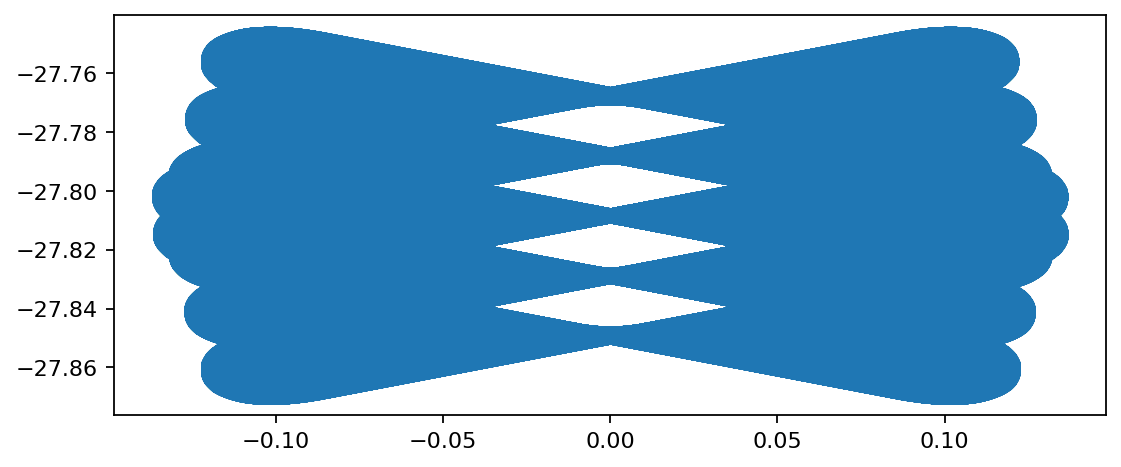

In [8]:
az, alt, flag, scan_eff, a = genLocalPath(az_size=0.2, alt_size=0.08, alt_step=0.02, acc = 0.05, scan_v=0.05, dt=0.001)
scan_path, scan_flag = genScanPath(T, alt, az, flag)
scan_path_sky = genPointingPath(T, scan_path, HA, mcmLat, dec)
print(T.shape, scan_path.shape, HA.shape,)
N1 =  0
N2 = -1
dN =  1
multi = 8000
fig, ax = plt.subplots(figsize=(8,6), dpi=160)
scat = ax.scatter(scan_path_sky[N1:N2:dN,0], scan_path_sky[N1:N2:dN,1], 
                   lw=0.5, alpha=.8)
# plt.xlim([-0.06,-0.045])
# plt.ylim([-27.8,-27.78])
ax.set_aspect(aspect=np.abs(round(np.cos(np.radians(dec)),2)))
plt.show()

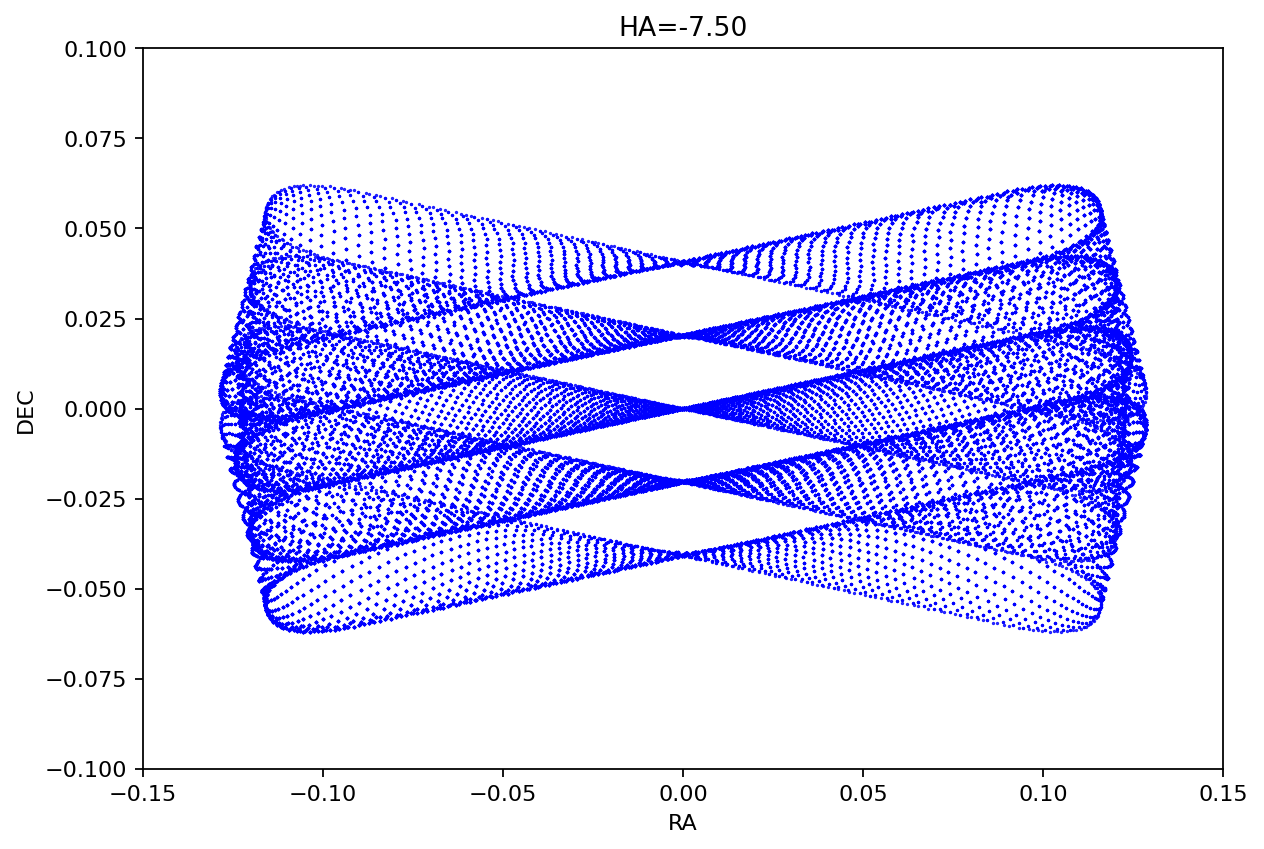

In [ ]:
az_size = 0.2
dec = 0

T_duration = 3600*15
dt = np.pi/7
T = np.arange(0,T_duration,dt)

HA = (-1*T_duration/2 + T)/3600.

az, alt, flag, scan_eff = genLocalPath(az_size=az_size,alt_size=0.08,alt_step=0.02)
scan_path, scan_flag = genScanPath(T, alt, az, flag)
scan_path_sky = genPointingPath(T, scan_path, HA, mcmLat, dec)

N1 = 0
N2 = 1
dN =  7
multi = 8000

fig, ax = plt.subplots(figsize=(8,6), dpi=160)

scat = ax.scatter(scan_path_sky[N1:N2:dN,0], scan_path_sky[N1:N2:dN,1], c='b', s=1., lw=0.5, alpha=.8)

plt.xlim([-0.15,0.15])
plt.ylim([dec-0.1,dec+0.1])
ax.set_aspect(aspect=1/np.abs(round(np.cos(np.radians(dec)),2)))

ax.set_xlabel("RA")
ax.set_ylabel("DEC")

ax.set_title("HA=%1.2f"%HA[0])

plt.tight_layout()

def animate(i):
    scat = ax.scatter(scan_path_sky[N1:i*multi:dN,0], scan_path_sky[N1:i*multi:dN,1], c='b', s=1., lw=0.5, alpha=.8)
    ax.set_title("HA=%1.2f"%HA[i*multi])
    return scat,

ani = animation.FuncAnimation(fig, animate, repeat=True,
                                    frames=len(T)//multi, interval=100)

# To save the animation using Pillow as a gif
writer = animation.PillowWriter(fps=10,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani.save('Scan_demo_dec0.gif', writer=writer)

# plt.show()

/tmp/ipykernel_44914/1728824810.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("pixel_pointing_demo.png", dpi=160)
/home/mvancuyck/anaconda3/envs/camb/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


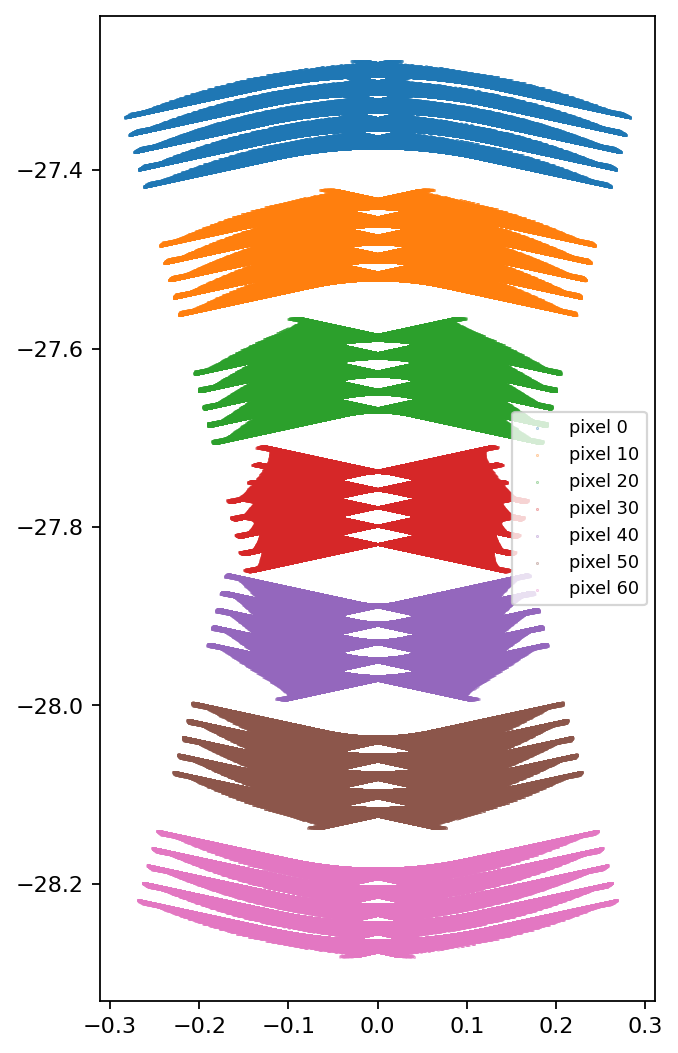

In [ ]:
fig, ax = plt.subplots(figsize=(6,8), dpi=160)

idx = np.arange(len(pixel_paths))[::10]

n = 11

for i in idx:
    plt.scatter(pointing_paths[i][::n,0], pointing_paths[i][::n,1], s=0.1, alpha=0.5, label= 'pixel %d'%i)
#     plt.plot(pointing_paths[i][:,0], pointing_paths[i][:,1], lw=0.1, alpha=0.6, label= 'pixel %d'%i)
ax.set_aspect(aspect=1)
plt.legend(frameon=1, fontsize=8)

plt.savefig("pixel_pointing_demo.png", dpi=160)

/tmp/ipykernel_44914/924351229.py:14: UserWarning: The following kwargs were not used by contour: 'lw'
  CS = ax1.contour(np.roll(np.sqrt(hit_map*np.roll(hit_map, 4, axis=1)),-2,axis=1),


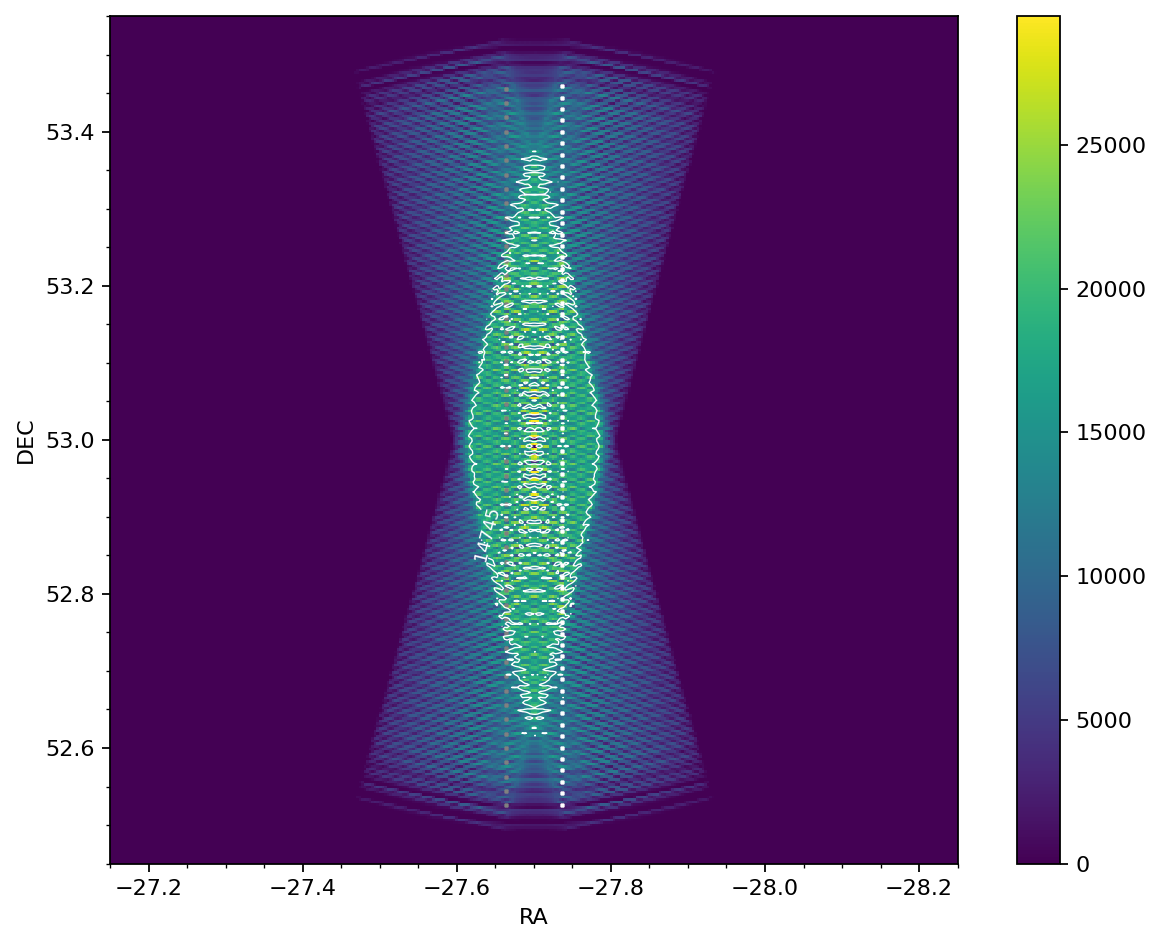

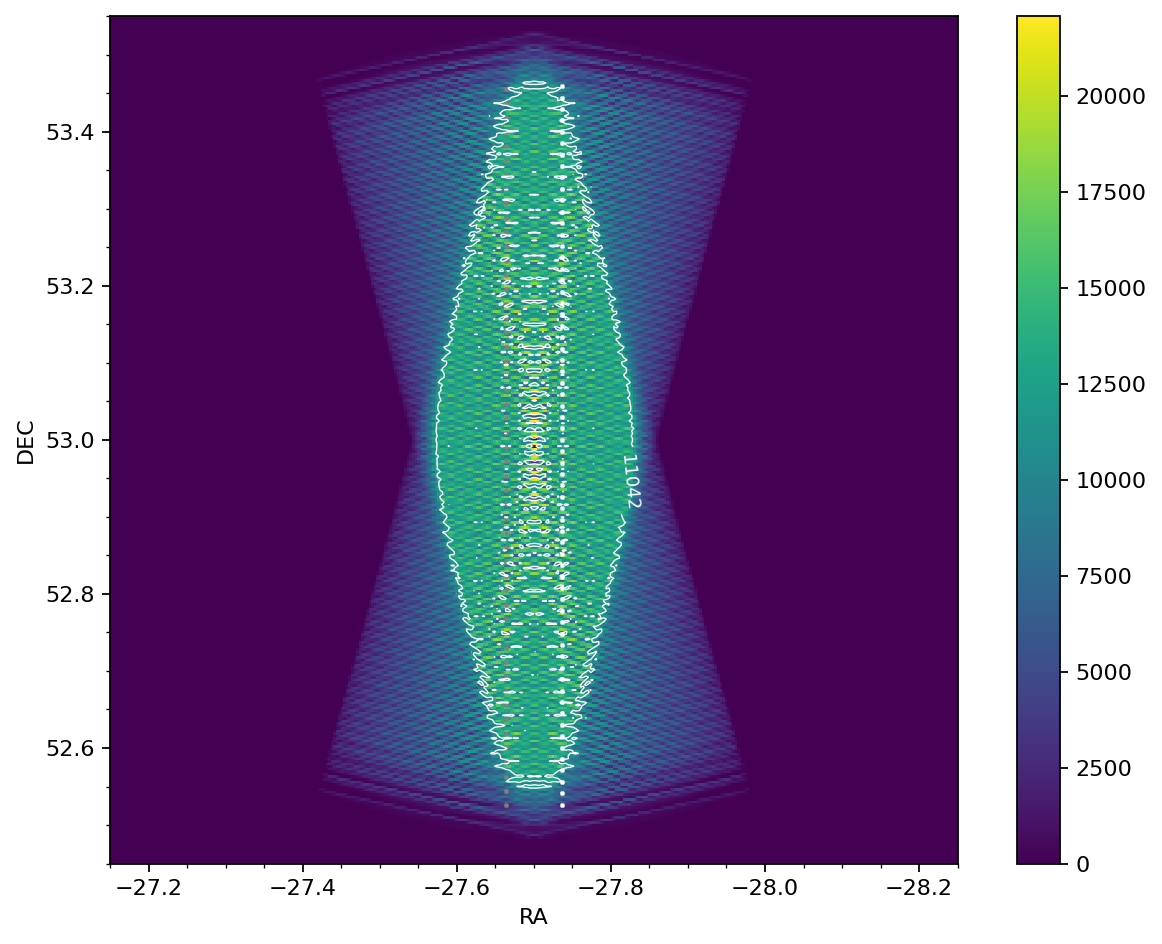

In [ ]:
savefig = 0
x_cen, y_cen =[-27.7,53]

for i, hit_map in enumerate(hit_maps): 

    fig, (ax1) = plt.subplots(1, figsize=(8,6), dpi=160)
    # fig.suptitle(t='TIM Deep field scan with az scan size = %1.1f deg\n'%az_sizes[i])

    maps = f_range
    img = ax1.imshow((hit_map), extent=[x_cen-maps, x_cen+maps,y_cen-maps, y_cen+maps,], \
        interpolation='nearest', origin='lower', vmin=0, vmax=np.max(hit_map), )
    fig.colorbar(img, ax=ax1,)
    
    CS = ax1.contour(np.roll(np.sqrt(hit_map*np.roll(hit_map, 4, axis=1)),-2,axis=1), 
                     levels=[0.5*np.max(hit_map)], lw=0.5, origin='lower', linewidths=0.6,\
                extent=[x_cen-maps, x_cen+maps,y_cen-maps, y_cen+maps,], colors='w')

    # CS = ax1.contour(hit_map, levels=[0.5*np.max(hit_map)], lw=0.5, origin='lower', linewidths=0.6,\
    #             extent=[x_cen-maps, x_cen+maps,y_cen-maps, y_cen+maps,], colors='w')
    ax.clabel(CS, inline=1, fontsize=8, )
    
    # img.set_clim(0,10000)

    ax1.scatter(pixel_xy[0]+x_cen, pixel_xy[1]+y_cen, s=2, marker='+', c='white',label='SW Spatial Pixels')
    ax1.scatter(pixel_xy_LW[0]+x_cen,pixel_xy_LW[1]+y_cen, s=2, marker='+', c='grey', label='LW Spatial Pixels')


    ax1.set_aspect(aspect=1)

    s = 0.55
    ax1.set_xlim([x_cen+s, x_cen-s,])
    ax1.set_ylim([y_cen-s, y_cen+s,])

    ax1.set_xlabel("RA")
    ax1.set_ylabel("DEC")

    ax1.minorticks_on()
    ax1.tick_params(which='minor', direction='out')

    # ax1.legend(frameon=1, fontsize=8)

    plt.tight_layout()

    if savefig:
        plt.savefig("sky_hitmap_deep_az%1.2f_15hrs_V4.png"%(az_sizes[i]), dpi=200)

In [ ]:
i=2
hits = hit_maps[0].flatten()
total_hits = len(T)*64
frac = timeFractionAbove(hit_maps[0],5000)
print(frac, np.sum(hits)/total_hits)

0.9073853944417184 36.48355246754542
